In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as stattools

import datetime

plt.style.use('ggplot')

/Users/mlara/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Description
---

**There are a total of 28 fields:**
- State Code : The code allocated by US EPA to each state
- County code : The code of counties in a specific state allocated by US EPA
- Site Num : The site number in a specific county allocated by US EPA
- Address: Address of the monitoring site
- State : State of monitoring site
- County : County of monitoring site
- City : City of the monitoring site
- Date Local : Date of monitoring

**The four pollutants (NO2, O3, SO2 and O3) each has 5 specific columns. For instance, for NO2:**

- NO2 Units : The units measured for NO2
- NO2 Mean : The arithmetic mean of concentration of NO2 within a given day
- NO2 AQI : The calculated air quality index of NO2 within a given day
- NO2 1st Max Value : The maximum value obtained for NO2 concentration in a given day
- NO2 1st Max Hour : The hour when the maximum NO2 concentration was recorded in a given day

**The total number of observations exceeds 1.7 million.**

**Note:** The creator of the dataset incorrectly included Mexico as a distinct state. 


In [2]:
filename = 'pollution_us_2000_2016.csv'
data_df =pd.read_csv(filename)

#Drop index column
data_df=data_df.drop(['Unnamed: 0'],axis = 1)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1746661 entries, 0 to 1746660
Data columns (total 28 columns):
State Code           int64
County Code          int64
Site Num             int64
Address              object
State                object
County               object
City                 object
Date Local           object
NO2 Units            object
NO2 Mean             float64
NO2 1st Max Value    float64
NO2 1st Max Hour     int64
NO2 AQI              int64
O3 Units             object
O3 Mean              float64
O3 1st Max Value     float64
O3 1st Max Hour      int64
O3 AQI               int64
SO2 Units            object
SO2 Mean             float64
SO2 1st Max Value    float64
SO2 1st Max Hour     int64
SO2 AQI              float64
CO Units             object
CO Mean              float64
CO 1st Max Value     float64
CO 1st Max Hour      int64
CO AQI               float64
dtypes: float64(10), int64(9), object(9)
memory usage: 373.1+ MB


In [3]:
#Check for Nulls
data_df.isnull().any()

State Code           False
County Code          False
Site Num             False
Address              False
State                False
County               False
City                 False
Date Local           False
NO2 Units            False
NO2 Mean             False
NO2 1st Max Value    False
NO2 1st Max Hour     False
NO2 AQI              False
O3 Units             False
O3 Mean              False
O3 1st Max Value     False
O3 1st Max Hour      False
O3 AQI               False
SO2 Units            False
SO2 Mean             False
SO2 1st Max Value    False
SO2 1st Max Hour     False
SO2 AQI               True
CO Units             False
CO Mean              False
CO 1st Max Value     False
CO 1st Max Hour      False
CO AQI                True
dtype: bool

#### Notes
- The only air quality measures that have null values are the air quality indices for SO2 and CO. 
- The primary focus of this investigation is to onjectively analyze and model pollutant concentration over time. 
- Air quality index is calculated based in some part on public health policies and may therefore be biased. For this reason, it will be excluded from the preliminary quantitative analysis. It will be re-examined afterwards in the context of the results from the gas concentration analyses.

# Data Cleaning
- Remove observations associated with 'Country of Mexico' to constrain analysis to US contributions.
- Convert the dates from strings to date-time objects.

In [4]:
temp = np.where(data_df['State']=='Country Of Mexico')
data_df = data_df.drop(temp[0].tolist(),axis = 0)

#Convert Date Strings to TimeStamps
data_df['Date'] = pd.to_datetime(data_df['Date Local'])
data_df = data_df.drop(['Date Local'],axis = 1)

data_df.head(5)

,State Code,County Code,Site Num,Address,State,County,City,NO2 Units,NO2 Mean,NO2 1st Max Value,...,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,Date
0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,Parts per billion,19.041667,49.0,...,3.000000,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN,2000-01-01
1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,Parts per billion,19.041667,49.0,...,3.000000,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0,2000-01-01
2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,Parts per billion,19.041667,49.0,...,2.975000,6.6,23,NaN,Parts per million,1.145833,4.2,21,NaN,2000-01-01
3,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,Parts per billion,19.041667,49.0,...,2.975000,6.6,23,NaN,Parts per million,0.878947,2.2,23,25.0,2000-01-01
4,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,Parts per billion,22.958333,36.0,...,1.958333,3.0,22,4.0,Parts per million,0.850000,1.6,23,NaN,2000-01-02


# Structure of Dataset

Number of Unique States: 46 
Number of Unique State Codes: 46 


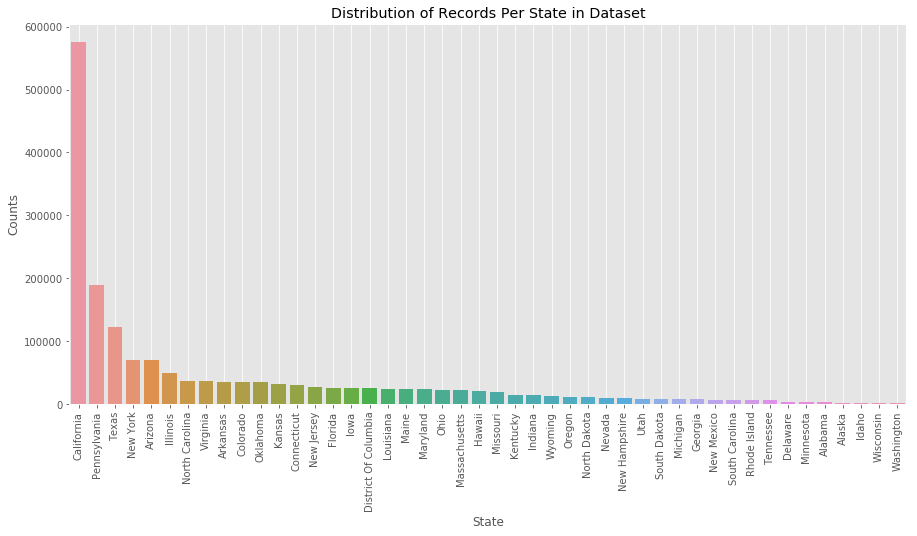

In [5]:
print('Number of Unique States: %s ' % len(data_df['State'].unique()))
print('Number of Unique State Codes: %s ' % len(data_df['State'].unique()))

state_record_count = pd.DataFrame(data_df['State'].value_counts())
state_record_count=state_record_count.reset_index()
state_record_count.columns = ['State','Counts']
state_record_count['Proportion'] = state_record_count['Counts']/state_record_count['Counts'].sum()

plt.figure(figsize=(15,7))
sns.barplot(data = state_record_count,x='State',y='Counts')
plt.xticks(rotation = 90)
plt.title('Distribution of Records Per State in Dataset')
plt.grid()
plt.plot()

state_record_cum = [np.sum(state_record_count['Proportion'][0:i]) for i in np.arange(state_record_count.shape[0])]
state_record_cum = pd.DataFrame(state_record_cum)
state_record_cum['State'] = state_record_count['State']
state_record_cum.columns=['CDF','State']

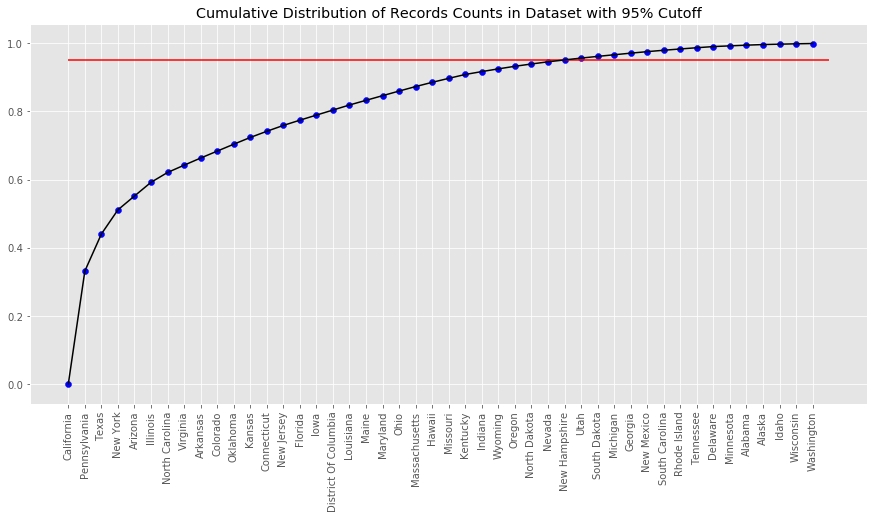

Total Number of Records from California: 576142
Proportion of Total Records from California: 0.331658372454
Minimum States Needed To Capture 95 Percent of Data: 30
States With 95 Percent of Records

0               California
1             Pennsylvania
2                    Texas
3                 New York
4                  Arizona
5                 Illinois
6           North Carolina
7                 Virginia
8                 Arkansas
9                 Colorado
10                Oklahoma
11                  Kansas
12             Connecticut
13              New Jersey
14                 Florida
15                    Iowa
16    District Of Columbia
17               Louisiana
18                   Maine
19                Maryland
20                    Ohio
21           Massachusetts
22                  Hawaii
23                Missouri
24                Kentucky
25                 Indiana
26                 Wyoming
27                  Oregon
28            North Dakota
29                

In [6]:
plt.figure(figsize=(15,7))
plt.scatter(np.arange(state_record_cum.shape[0]),state_record_cum['CDF'],color='blue')
plt.plot(np.arange(state_record_cum.shape[0]),state_record_cum['CDF'],color = 'black')
plt.hlines(y=0.95,xmin = 0,xmax=state_record_cum.shape[0],color = 'red')
plt.xticks(np.arange(state_record_cum.shape[0]),state_record_cum['State'],rotation = 90)
plt.title('Cumulative Distribution of Records Counts in Dataset with 95% Cutoff')
plt.show()

print('Total Number of Records from California: %s' % state_record_count['Counts'][0])
print('Proportion of Total Records from California: %s' % state_record_count['Proportion'][0])

temp = state_record_cum['CDF'].values
temp = np.where(temp<=0.95)[0]
temp=len(temp)
print('Minimum States Needed To Capture 95 Percent of Data: %s' % temp)

print('States With 95 Percent of Records\n')
print state_record_cum['State'][0:temp]

- There are a total of **46 states** in the dataset. 
- The **state with the most records is California** with a total of 576142 records.
- Data from California comprises only **33.1% of the entire dataset**.


- In order to capture 95% of all the data, only 30 of the states need to be analyzed. 
- A list of the states with the highest contributions could be useful for **reducing noise** in later time analyses.

In [7]:
top_states_list=['California','Pennsylvania',
             'Texas','New York',
             'Arizona','Illinois',
             'North Carolina', 'Virginia',
             'Arkansas', 'Colorado',
             'Oklahoma','Kansas',
             'Connecticut', 'New Jersey',
             'Florida', 'Iowa',
             'District Of Columbia', 'Louisiana',
             'Maine', 'Maryland',
             'Ohio', 'Massachusetts',
             'Hawaii', 'Missouri',
             'Kentucky', 'Indiana', 
             'Wyoming', 'Oregon', 
             'North Dakota', 'Nevada']

### National Mean Daily Pollution Concentration per Year

In [8]:
avg_NO2=[]
avg_CO=[]
avg_SO2=[]
avg_O3=[]

std_NO2=[]
std_CO=[]
std_SO2=[]
std_O3=[]

temp_df=[]
for i in np.linspace(start = 2000, stop = 2016,num=17,endpoint=True):
    temp_df = data_df[data_df['Date'].dt.year == i]
    avg_NO2.append(temp_df['NO2 Mean'].mean())    
    avg_CO.append(temp_df['CO Mean'].mean())
    avg_SO2.append(temp_df['SO2 Mean'].mean())
    avg_O3.append(temp_df['O3 Mean'].mean())
    
    std_NO2.append(temp_df['NO2 Mean'].std())    
    std_CO.append(temp_df['CO Mean'].std())
    std_SO2.append(temp_df['SO2 Mean'].std())
    std_O3.append(temp_df['O3 Mean'].std())
    
year_data_df =pd.DataFrame({'avg_NO2':avg_NO2,
                                'avg_CO':avg_CO,
                                'avg_SO2':avg_SO2,
                                'avg_O3':avg_O3,
                            
                                'std_NO2':std_NO2,
                                'std_CO':std_CO,
                                'std_SO2':std_SO2,
                                'std_O3':std_O3,
                            
                                'year':np.linspace(start = 2000, stop = 2016,num=17,endpoint=True)
                           })
year_data_df['year'] = year_data_df['year'].astype(np.int)


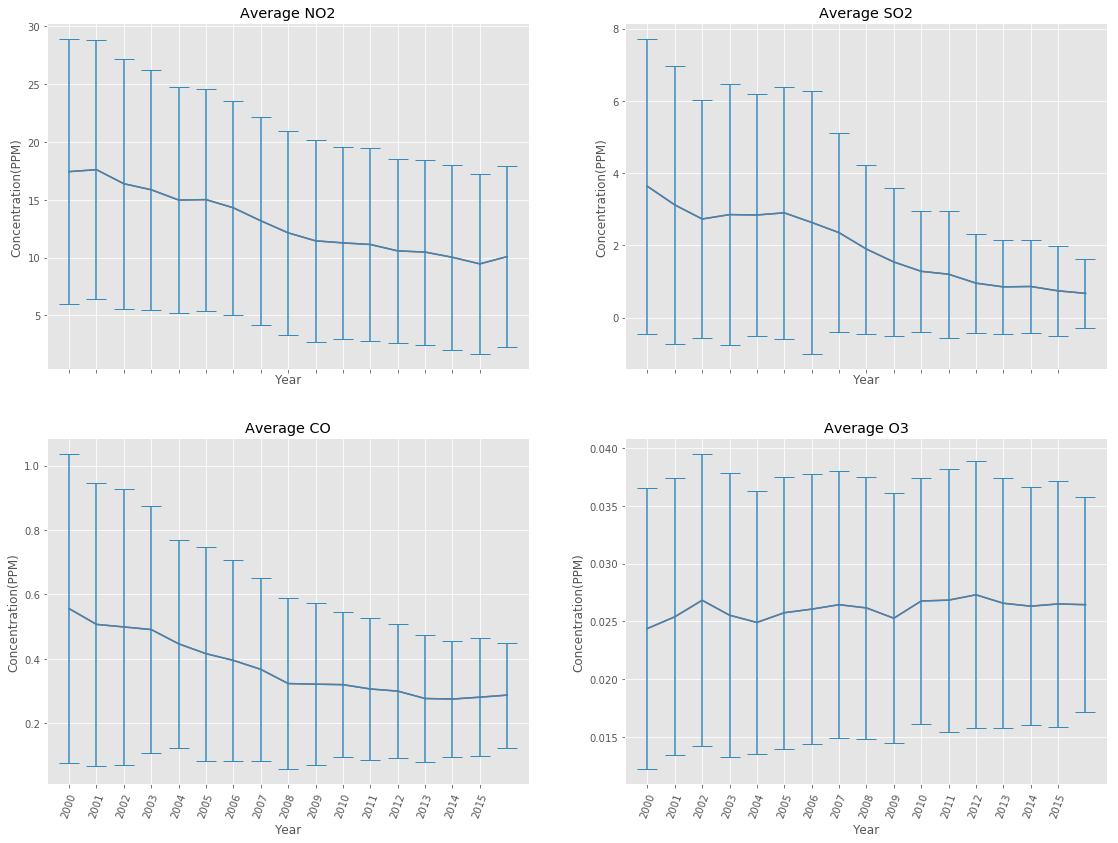

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(19,14), sharex=True)

axes[0,0].plot(year_data_df['avg_NO2'])
axes[0,0].errorbar(x=np.arange(year_data_df.shape[0]),y=year_data_df['avg_NO2'],
                   yerr=year_data_df['std_NO2'],
                    capsize=10)
axes[0,0].title.set_text('Average NO2')


axes[0,1].plot(year_data_df['avg_SO2'])
axes[0,1].errorbar(x=np.arange(year_data_df.shape[0]),y=year_data_df['avg_SO2'],
                   yerr=year_data_df['std_SO2'],
                    capsize=10)
axes[0,1].title.set_text('Average SO2')

axes[1,0].plot(year_data_df['avg_CO'])
axes[1,0].errorbar(x=np.arange(year_data_df.shape[0]),y=year_data_df['avg_CO'],
                   yerr=year_data_df['std_CO'],
                    capsize=10)
axes[1,0].title.set_text('Average CO')

axes[1,1].plot(year_data_df['avg_O3'])
axes[1,1].errorbar(x=np.arange(year_data_df.shape[0]),y=year_data_df['avg_O3'],
                   yerr=year_data_df['std_O3'],
                    capsize=10)
axes[1,1].title.set_text('Average O3')

plt.setp(axes,xlabel ='Year')
plt.setp(axes,ylabel ='Concentration(PPM)')
plt.setp(axes, xticks=np.arange(16), xticklabels=year_data_df['year'])
plt.setp(axes[1,0].xaxis.get_majorticklabels(), rotation=70 )
plt.setp(axes[1,1].xaxis.get_majorticklabels(), rotation=70 )

plt.show()


In [10]:
print('Change in Mean CO Concentration(PPM) from 2000-2016: %s' % -(year_data_df['avg_CO'][0]-year_data_df['avg_CO'][16]))
print('Change in Mean NO2 Concentration(PPM) from 2000-2016: %s' % -(year_data_df['avg_NO2'][0]-year_data_df['avg_NO2'][16]))
print('Change in Mean SO2 Concentration(PPM) from 2000-2016: %s' % -(year_data_df['avg_SO2'][0]-year_data_df['avg_SO2'][16]))
print('Change in Mean O3 Concentration(PPM) from 2000-2016: %s' % -(year_data_df['avg_O3'][0]-year_data_df['avg_O3'][16]))

print('\nChange in CO Concentration Variability(PPM) from 2000-2016: %s' % -(year_data_df['std_CO'][0]-year_data_df['std_CO'][16]))
print('Change in NO2 Concentration Variability(PPM) from 2000-2016: %s' % -(year_data_df['std_NO2'][0]-year_data_df['std_NO2'][16]))
print('Change in SO2 Concentration Variability(PPM) from 2000-2016: %s' % -(year_data_df['std_SO2'][0]-year_data_df['std_SO2'][16]))
print('Change in O3 Concentration Variability(PPM) from 2000-2016: %s' % -(year_data_df['std_O3'][0]-year_data_df['std_O3'][16]))

Change in Mean CO Concentration(PPM) from 2000-2016: -0.268677582927
Change in Mean NO2 Concentration(PPM) from 2000-2016: -7.35316423859
Change in Mean SO2 Concentration(PPM) from 2000-2016: -2.96212551038
Change in Mean O3 Concentration(PPM) from 2000-2016: 0.00206446809334

Change in CO Concentration Variability(PPM) from 2000-2016: -0.316665194354
Change in NO2 Concentration Variability(PPM) from 2000-2016: -3.64707883583
Change in SO2 Concentration Variability(PPM) from 2000-2016: -3.12253650549
Change in O3 Concentration Variability(PPM) from 2000-2016: -0.00285292030945


- Average **yearly concentrations** of NO2, SO2, and CO have observable **decreased** from 2000 to 2016. 


- The **variability of yearly concentrations** of NO2 and SO2 are **decreasing with the mean concentrations**, suggesting that the variation of gas generation across all states has also decreased. This may be the result of the introduction of public policies requiring stricter control of emitted pollution and the crreation of more efficient technologies that produce lower quantities of pollutants.


- Neither the mean concentrations or variability of ozone(O3) demonstrate any consistent trend over the 16 year year period documented in the data. 

## Time Series Visualization of CO and SO2 Concentrations

In [11]:
#Aggregate Data Using a State Grain for the Top States
top_data_df=data_df.loc[data_df['State'].isin(top_states_list)]
top_date_agg_statedate_df = top_data_df.groupby([ 'State','Date']).mean()
top_date_agg_statedate_df=pd.DataFrame(top_date_agg_statedate_df.to_records())
top_date_agg_statedate_df['Date'] = top_date_agg_statedate_df['Date'].dt.date

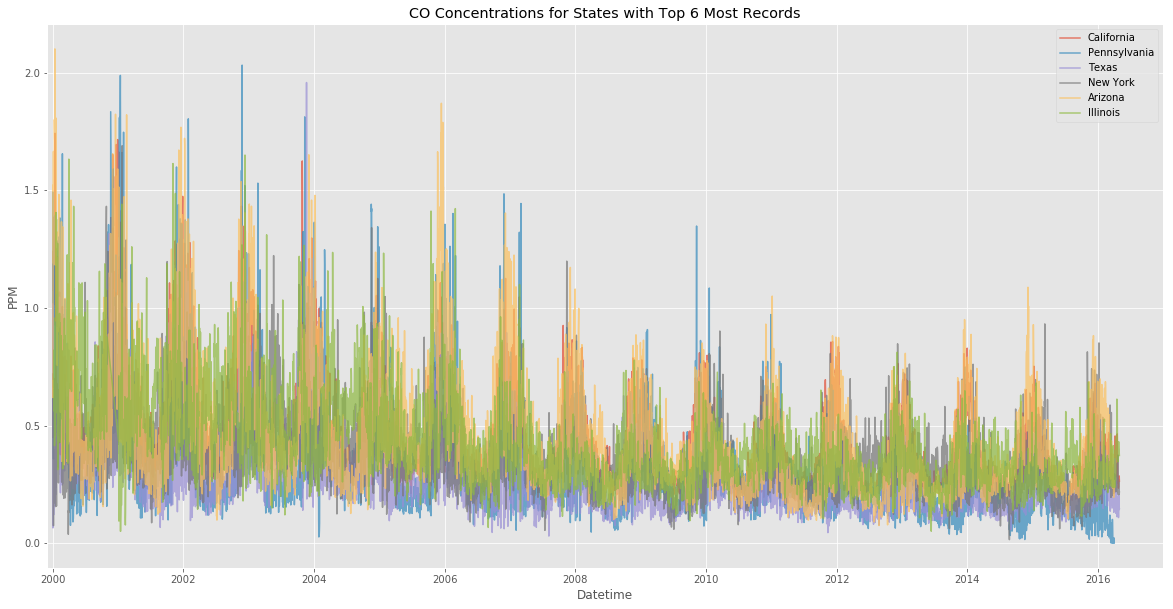

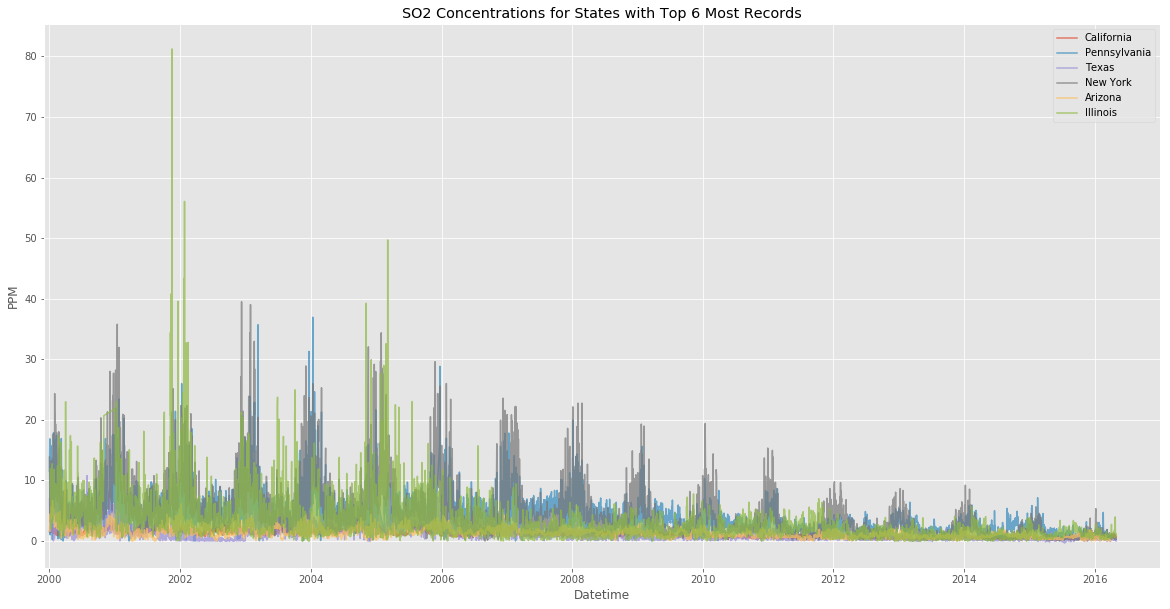

In [12]:
fig, ax = plt.subplots(figsize=(20,10))

for i in top_states_list[0:6]:
    temp=top_date_agg_statedate_df[(top_date_agg_statedate_df['State']==i)]
    ax.plot_date(x=temp['Date'],y=temp['CO Mean'],fmt='-',label=i,alpha = 0.7)

ax.set_xlim([datetime.date(1999, 12, 1), datetime.date(2016, 12, 31)])
ax.legend()
plt.ylabel('PPM')
plt.xlabel('Datetime')
plt.title('CO Concentrations for States with Top 6 Most Records')

fig, ax = plt.subplots(figsize=(20,10))
for i in top_states_list[0:6]:
    temp=top_date_agg_statedate_df[(top_date_agg_statedate_df['State']==i)]
    ax.plot_date(x=temp['Date'],y=temp['SO2 Mean'],fmt='-',label=i,alpha = 0.7)
ax.set_xlim([datetime.date(1999, 12, 1), datetime.date(2016, 12, 31)])
ax.legend()
plt.ylabel('PPM')
plt.xlabel('Datetime')
plt.title('SO2 Concentrations for States with Top 6 Most Records')

- Time series plots demonstrate periodic peaks in SO2 and CO production occurring at the beginnining and middle of each calendar year. This is a **seasonal behavior** that will need to be considered during the model selection process. 

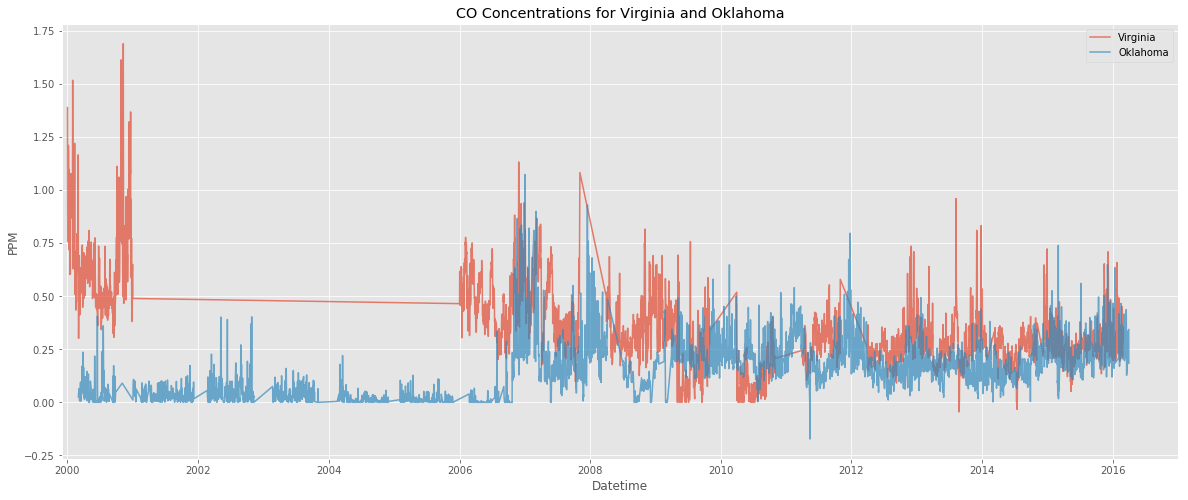

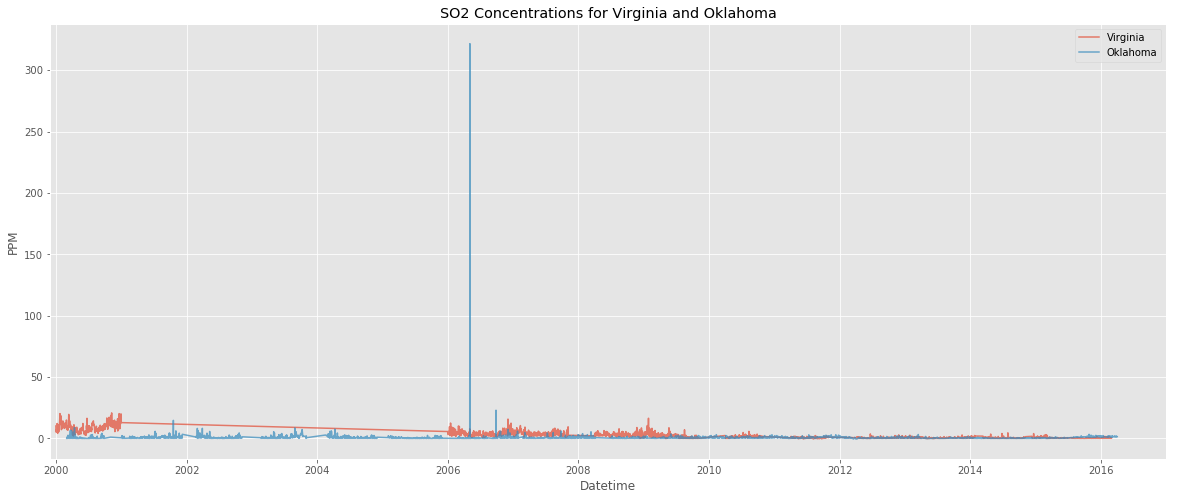

In [13]:
fig, ax = plt.subplots(figsize=(20,8))

for i in ['Virginia','Oklahoma']:
    temp=top_date_agg_statedate_df[(top_date_agg_statedate_df['State']==i)]
    ax.plot_date(x=temp['Date'],y=temp['CO Mean'],fmt='-',label=i,alpha = 0.7)

ax.set_xlim([datetime.date(1999, 12, 1), datetime.date(2016, 12, 31)])
ax.legend()
plt.ylabel('PPM')
plt.xlabel('Datetime')
plt.title('CO Concentrations for Virginia and Oklahoma')

fig, ax = plt.subplots(figsize=(20,8))
for i in ['Virginia','Oklahoma']:
    temp=top_date_agg_statedate_df[(top_date_agg_statedate_df['State']==i)]
    ax.plot_date(x=temp['Date'],y=temp['SO2 Mean'],fmt='-',label=i,alpha = 0.7)
ax.set_xlim([datetime.date(1999, 12, 1), datetime.date(2016, 12, 31)])
ax.legend()
plt.ylabel('PPM')
plt.xlabel('Datetime')
plt.title('SO2 Concentrations for Virginia and Oklahoma')

In [14]:
temp=top_date_agg_statedate_df[(top_date_agg_statedate_df['State']=='Oklahoma')]
spikes = temp[temp['SO2 Mean']>20]
print('Mean of All Mean Oklahoma SO2 Concentration Data: %s' % temp['SO2 Mean'].mean())
print('Standard Deviation of All Oklahoma Mean SO2 Concentration Data: %s' % temp['SO2 Mean'].std())

print('\nPrimary Spike Value: %s PPM' % spikes['SO2 Mean'].values[0])
print('Date of Primary Spike in Mean SO2 for Oklahoma: %s' % str(spikes['Date'].values[0]))

print('\nSecondary Spike Value: %s PPM' % spikes['SO2 Mean'].values[1])
print('Date of Secondary Spike in Mean SO2 for Oklahoma: %s' % str(spikes['Date'].values[1]))

Mean of All Mean Oklahoma SO2 Concentration Data: 0.747209716179
Standard Deviation of All Oklahoma Mean SO2 Concentration Data: 4.64138532373

Primary Spike Value: 321.6125 PPM
Date of Primary Spike in Mean SO2 for Oklahoma: 2006-05-04

Secondary Spike Value: 22.9875 PPM
Date of Secondary Spike in Mean SO2 for Oklahoma: 2006-09-27


**NB:** It should be noted that data is not present and reliable for for every state in the dataset. A cursory analysis of mean SO2 and CO concentrations reveals that data for these gases are unavailable for Virgina from 2001-2006. In addition, it appears that the SO2 data for Oklahoma has 2 outliers that deviate significantly from the overall gas levels for Oklahoma.

## Exploratory Data Analysis and Modeling
- SARIMA and SARMA models are the most likely candidates based on both the inherent seasonality of the data and the lack of possible explanatory variables. SARIMAX and SARMAX models are being excluded from the modeling portion of this notebook because it is assumed that the gas measured gas levels are independent of each other.

**NB:** The assumption of independence of the measured gas levels is made for the sake of simplifying the analysis. Alternatively, the gas levels could be reasonably considered to be dependent on each other because industrial processes, such as oil refinement and natural gas processing, have been documented to produce both CO and SO2.

In [15]:
##Separate Each Series for each State to Determine Order of Differencing for Each State
##The series DO NOT have the same lengths

top_reduce = top_date_agg_statedate_df.loc[top_date_agg_statedate_df['State'].isin(top_states_list[0:6])]

#CO
CO_mean_list = []
for i in top_states_list[0:6]:
    CO_mean_list.append(top_date_agg_statedate_df.loc[top_date_agg_statedate_df['State']==i]['CO Mean']) 

#SO2
SO2_mean_list = []
for i in top_states_list[0:6]:
    SO2_mean_list.append(top_date_agg_statedate_df.loc[top_date_agg_statedate_df['State']==i]['SO2 Mean']) 


In [16]:
print('Check Stationarity of 1st Differences of CO')

print('\nKPSS Ho: Stationary and Non-Seasonal')
for i in np.arange(len(CO_mean_list)):
    temp = stattools.kpss(CO_mean_list[i].diff().values[1:])
    print('%s KPSS p-value: %s ' % (str(top_states_list[i]),temp[1]))

    
print('\nAdjusted Dickey-Fuller Ho: Non-Stationary and Non-Seasonal')
for i in np.arange(len(CO_mean_list)):
    temp = stattools.adfuller(CO_mean_list[i].diff().values[1:])
    print('%s ADF p-value: %s ' % (str(top_states_list[i]),temp[1]))

Check Stationarity of 1st Differences of CO

KPSS Ho: Stationary and Non-Seasonal
California KPSS p-value: 0.1 
Pennsylvania KPSS p-value: 0.1 
Texas KPSS p-value: 0.1 
New York KPSS p-value: 0.1 
Arizona KPSS p-value: 0.1 
Illinois KPSS p-value: 0.1 

Adjusted Dickey-Fuller Ho: Non-Stationary and Non-Seasonal


/Users/mlara/anaconda/lib/python2.7/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


California ADF p-value: 0.0 
Pennsylvania ADF p-value: 2.13923345012e-29 
Texas ADF p-value: 0.0 
New York ADF p-value: 0.0 
Arizona ADF p-value: 0.0 
Illinois ADF p-value: 0.0 


In [17]:
print('Check Stationarity of 1st Differences of SO2')

print('\nKPSS Ho: Stationary and Non-Seasonal')
for i in np.arange(len(SO2_mean_list)):
    temp = stattools.kpss(SO2_mean_list[i].diff().values[1:])
    print('%s KPSS p-value: %s ' % (str(top_states_list[i]),temp[1]))

    
print('\nAdjusted Dickey-Fuller Ho: Non-Stationary and Non-Seasonal')
for i in np.arange(len(SO2_mean_list)):
    temp = stattools.adfuller(SO2_mean_list[i].diff().values[1:])
    print('%s ADF p-value: %s ' % (str(top_states_list[i]),temp[1]))

Check Stationarity of 1st Differences of SO2

KPSS Ho: Stationary and Non-Seasonal
California KPSS p-value: 0.1 
Pennsylvania KPSS p-value: 0.1 
Texas KPSS p-value: 0.1 
New York KPSS p-value: 0.1 
Arizona KPSS p-value: 0.1 
Illinois KPSS p-value: 0.1 

Adjusted Dickey-Fuller Ho: Non-Stationary and Non-Seasonal
California ADF p-value: 0.0 
Pennsylvania ADF p-value: 0.0 
Texas ADF p-value: 0.0 
New York ADF p-value: 2.80130875242e-30 
Arizona ADF p-value: 2.44971988043e-30 
Illinois ADF p-value: 0.0 


In [18]:
def tsplot(y, lags=None, title='', figsize=(14, 3),zero=True):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
       Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (1, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    
#     acf_ax  = plt.subplot2grid(layout, (0, 0))
#     pacf_ax = plt.subplot2grid(layout, (0, 0))

    ts_ax.plot(y)    
    ts_ax.set_title('Time Series Plot')
    
    hist_ax.hist(y,bins=40)
    hist_ax.set_title('Histogram')
    plt.tight_layout()
        
    plt.figure(figsize=(2*figsize[0],figsize[1]))
    acf_ax = plt.subplot2grid(layout, (0, 0))
    smt.graphics.plot_acf(y,lags=lags, ax=acf_ax,zero=zero,use_vlines=False,marker='',linestyle = '-')
    #plt.xscale('log')
    acf_ax.set_ylim(-.5,.5)
    
    plt.figure(figsize=(2*figsize[0],figsize[1]))
    pacf_ax = plt.subplot2grid(layout, (0, 0))
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax,zero=zero,use_vlines=False,marker='',linestyle = '-')
    #plt.xscale('log')
    pacf_ax.set_ylim(-.5,.5)
    
    plt.tight_layout()

### Diagnostic Plots for CO and SO2

Values for the autocorrelation function(ACF) for each state appear to become statistically insignificant at lower lags than each state's corresponding partial autocorrelation functions(PACF). In addition, the PACF's for every state decreases in a tailed fashion, whereas the ACFs appear to 'cutoff' suddenly. These observations suggest that the **moving average model(MA)** and **autoregressive moving average model(ARMA)** may be appropriate forecasting candidates. 

A purely autoregressive model is less likely to be appropriate for these time series because none of the PACF plots for any state or gas exhibits a sudden 'cutoff' after a certain number of lags.

**Note:** ACF and PACF plots taken up to lags of ~3 Years (3/16 of each series's total length)

---Differenced CO Time Series Plots for California ---


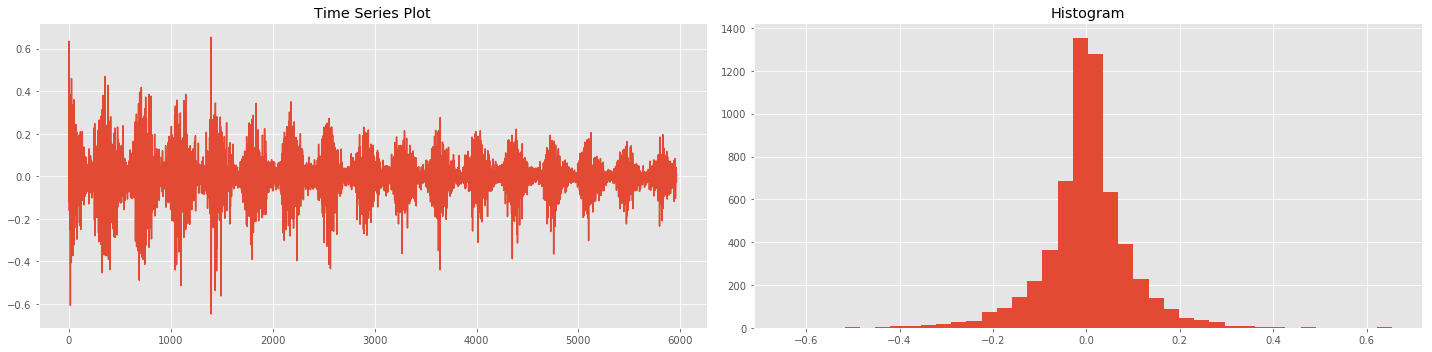

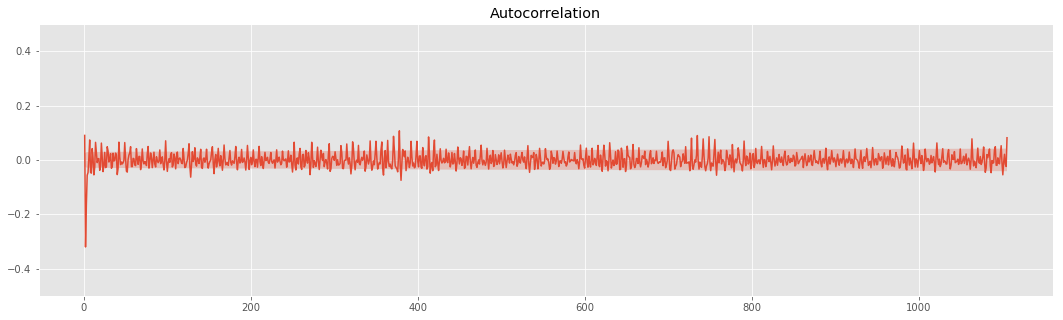

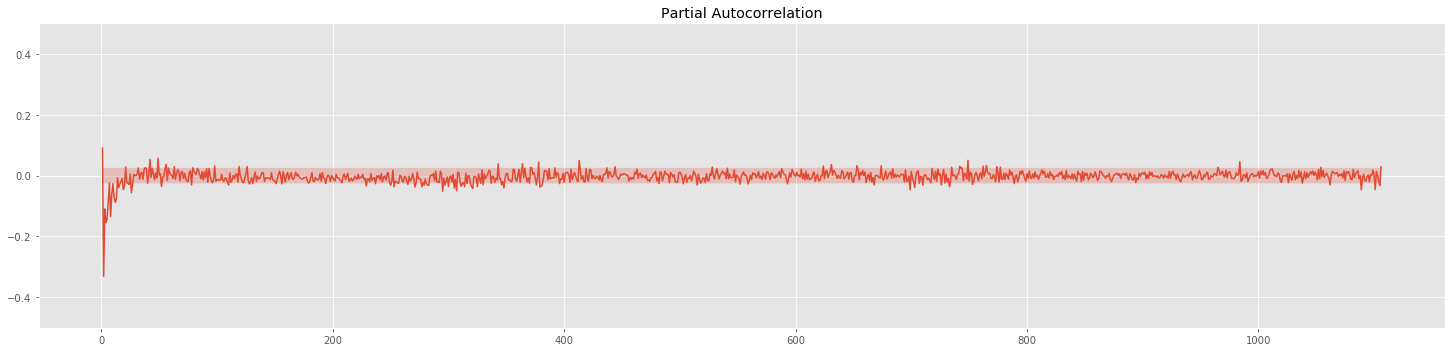

---Differenced CO Time Series Plots for Pennsylvania ---


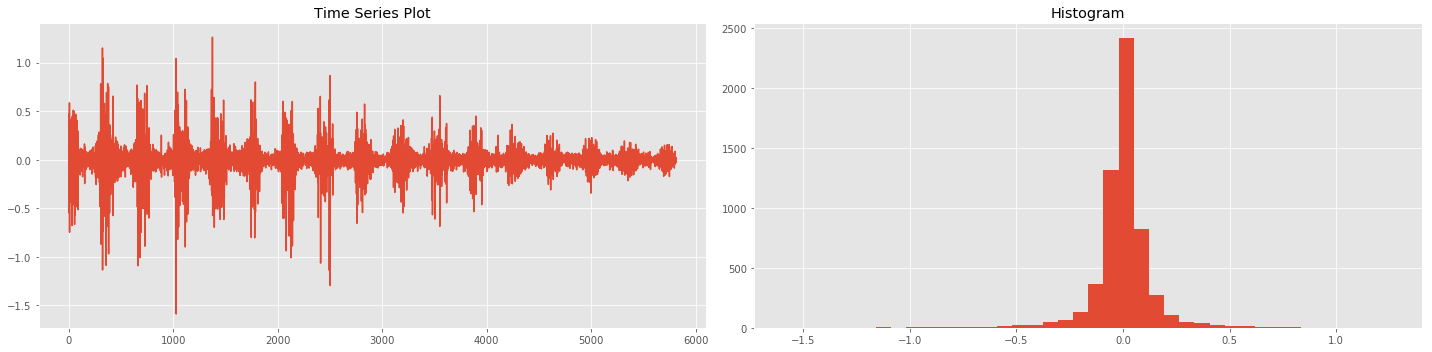

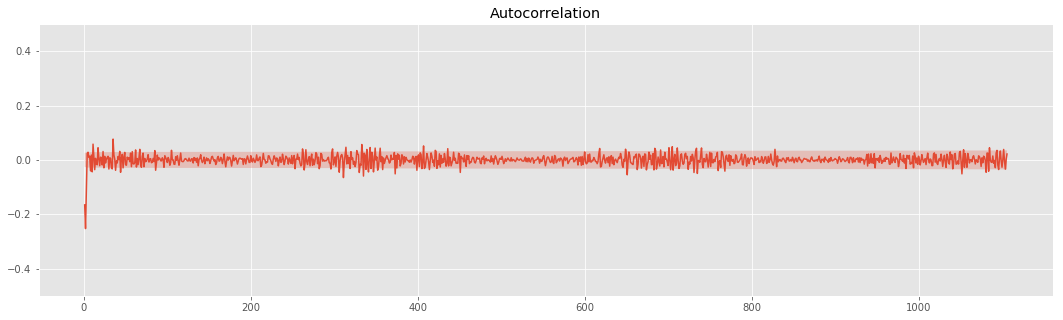

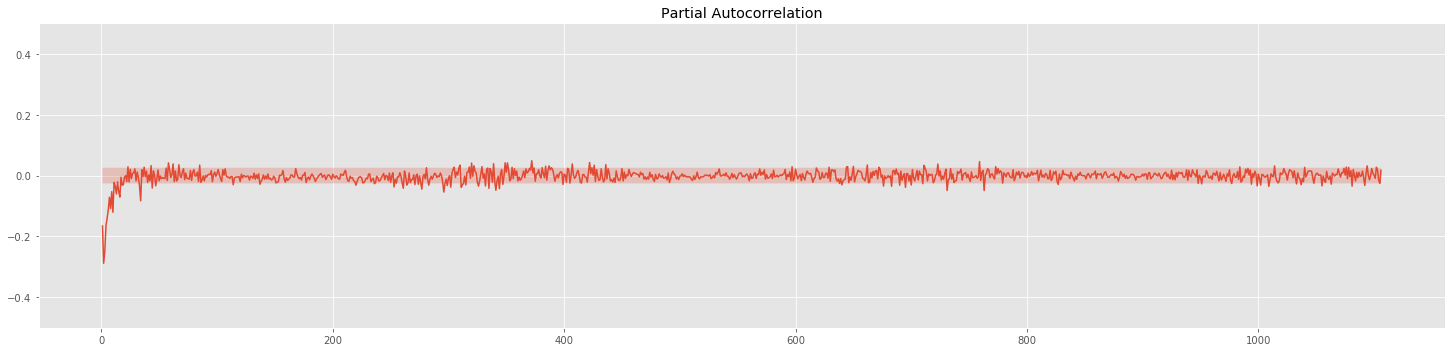

---Differenced CO Time Series Plots for Texas ---


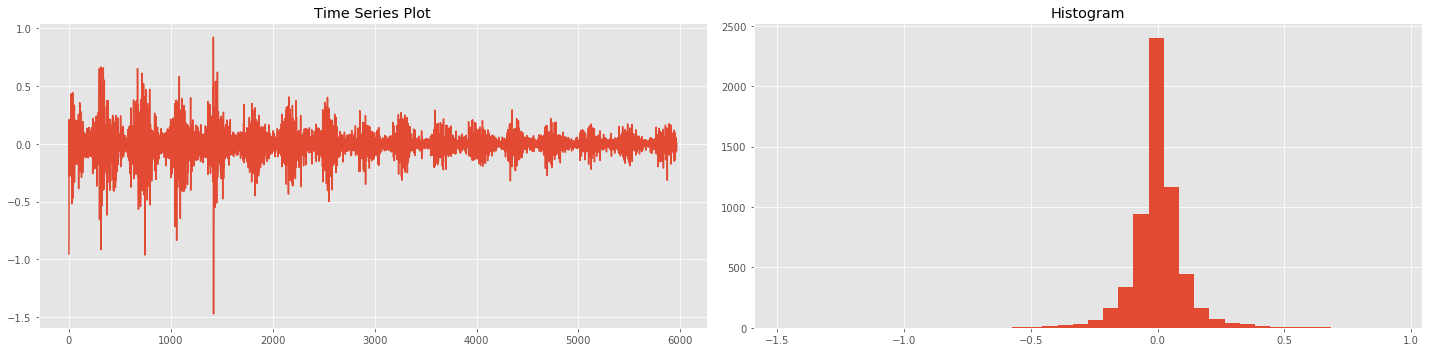

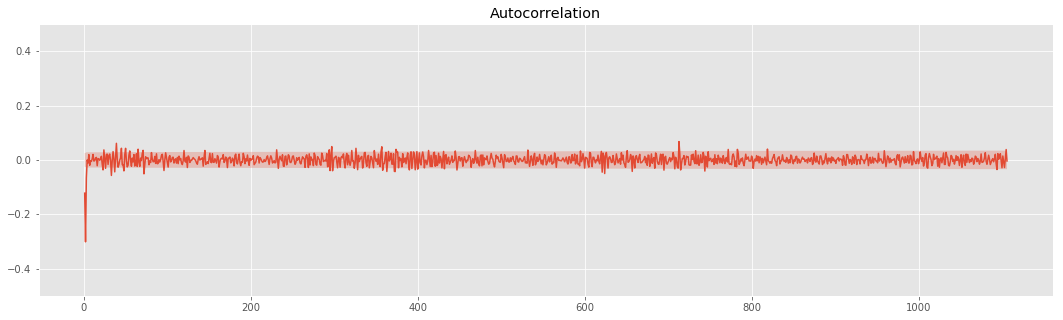

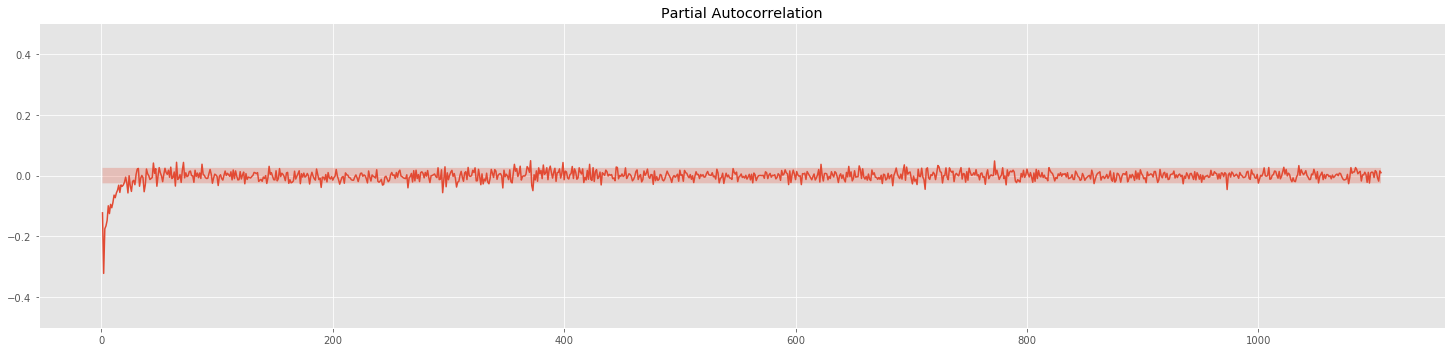

---Differenced CO Time Series Plots for New York ---


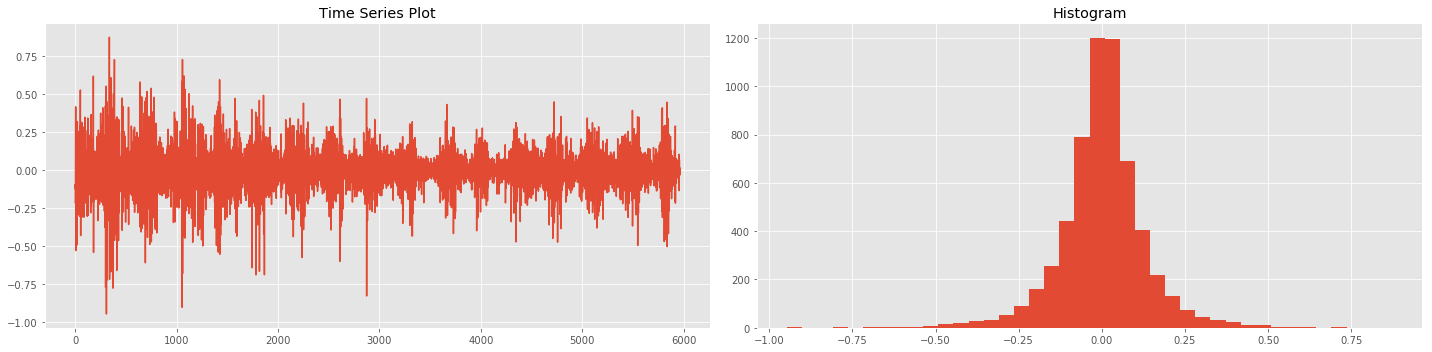

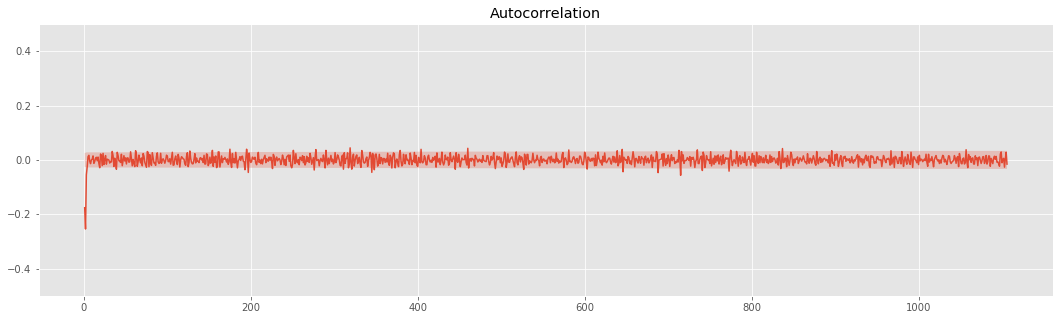

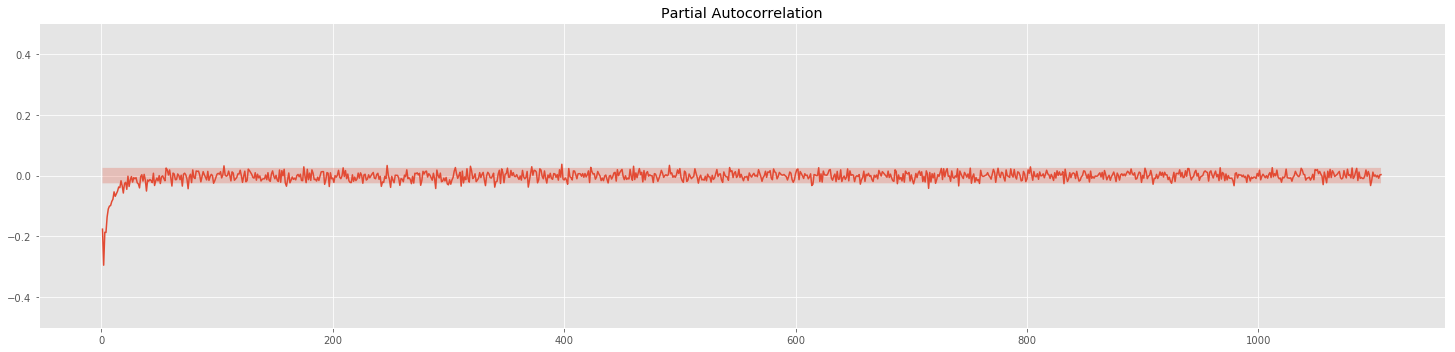

---Differenced CO Time Series Plots for Arizona ---


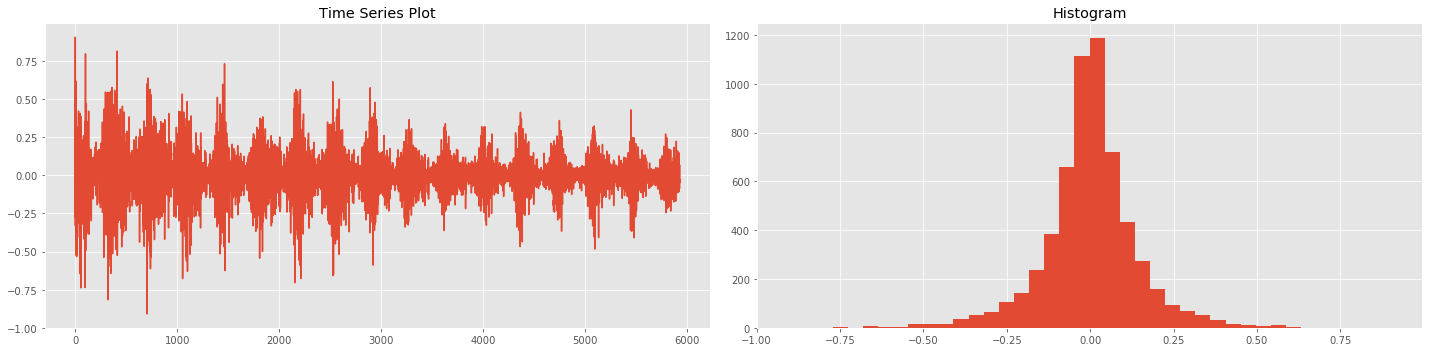

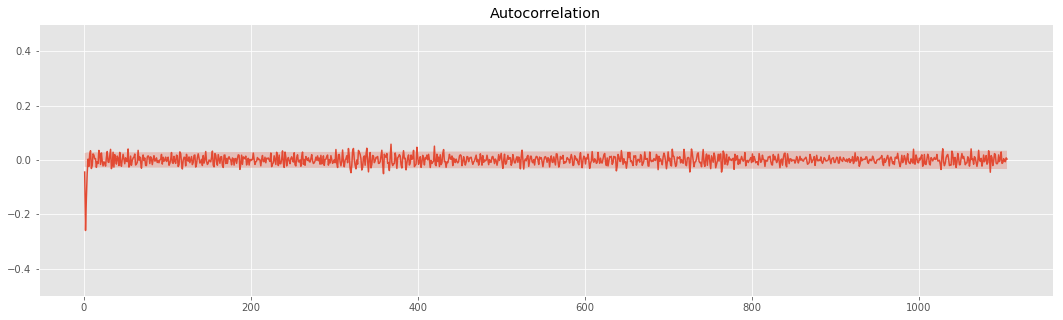

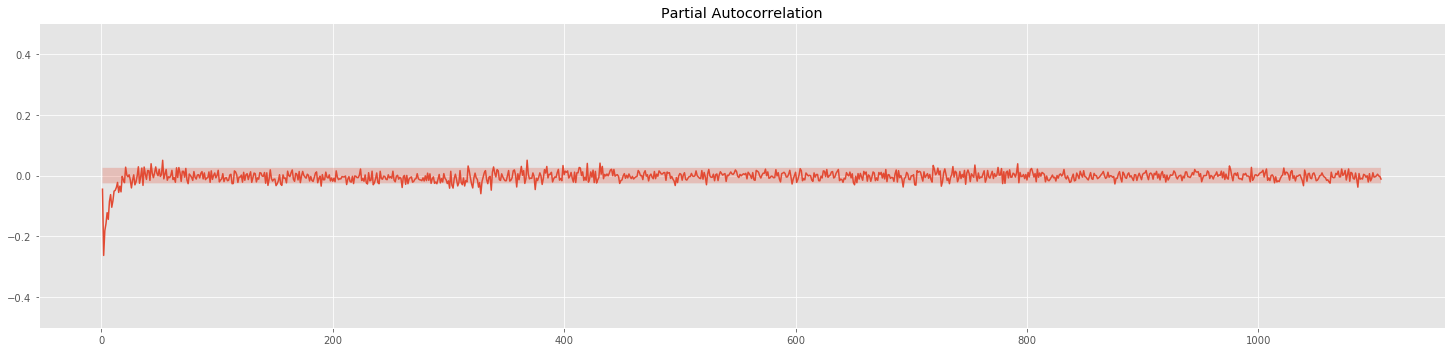

---Differenced CO Time Series Plots for Illinois ---


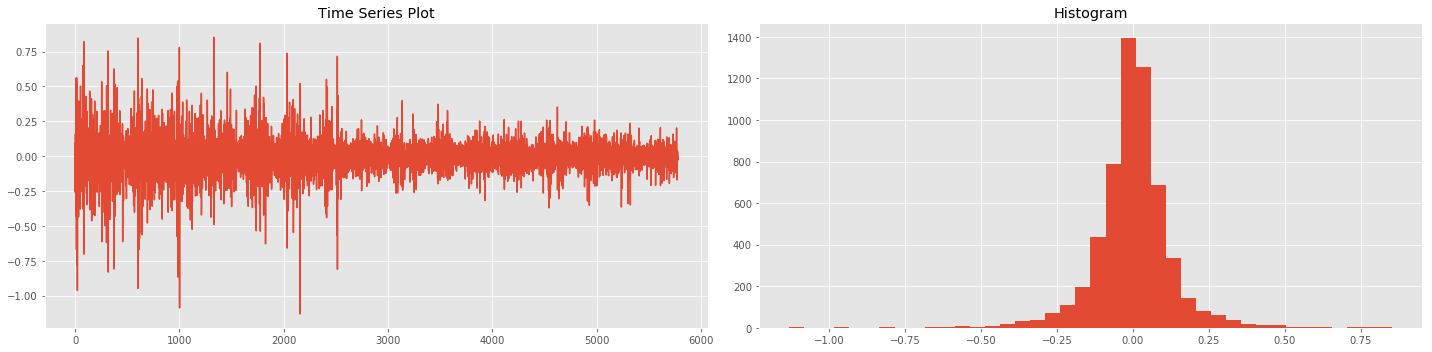

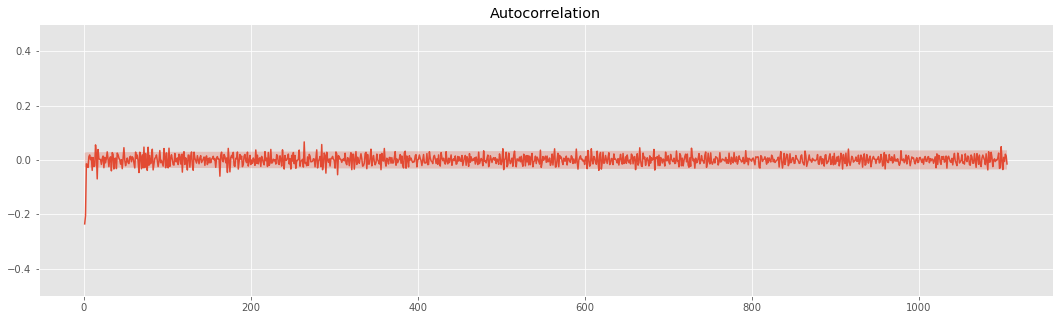

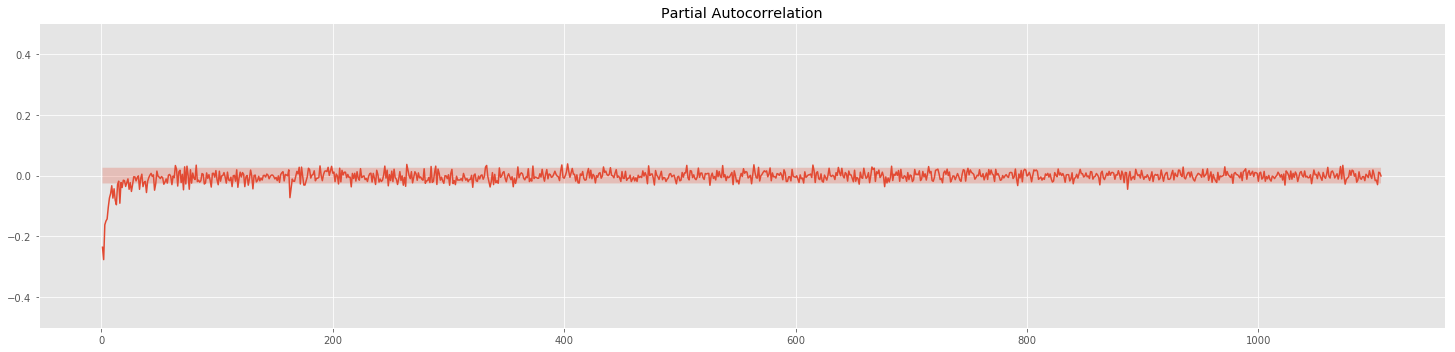

In [19]:
lags = []
for i in CO_mean_list:
    lags.append(len(i))

#The Number of Lags Corresponds Approximately to 3 Years
lags = np.int(np.mean(lags)*3/16)

for i in np.arange(len(CO_mean_list)):
    print('---Differenced CO Time Series Plots for %s ---' % top_states_list[i])
    tsplot(CO_mean_list[i].diff().values[1:],figsize=(20,5), lags = lags,zero=False)
    plt.show()

---Differenced SO2 Time Series Plots for California ---


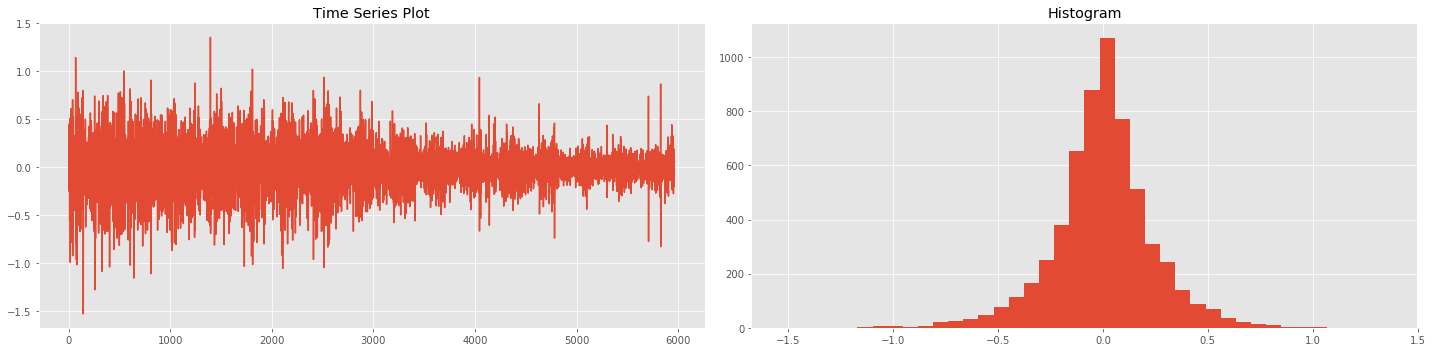

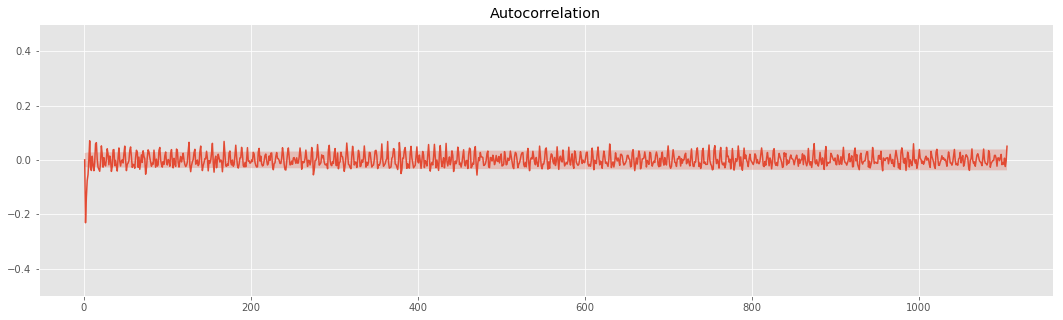

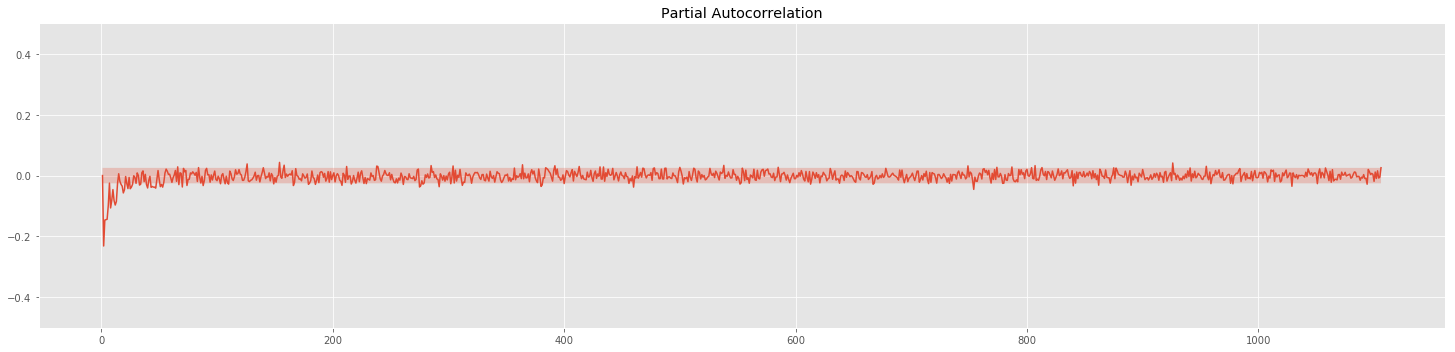

---Differenced SO2 Time Series Plots for Pennsylvania ---


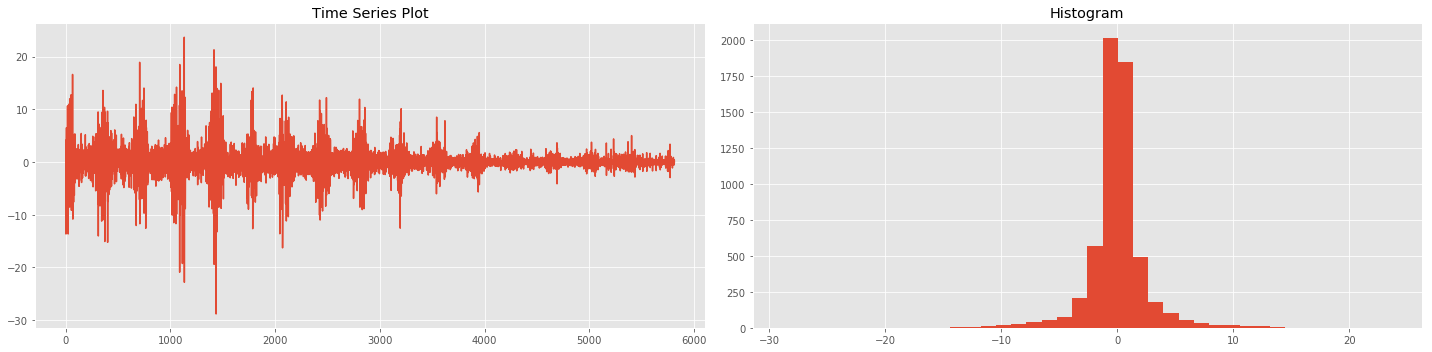

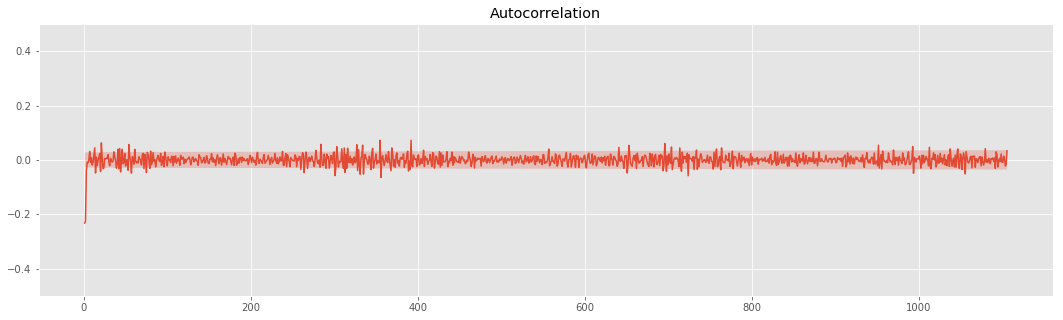

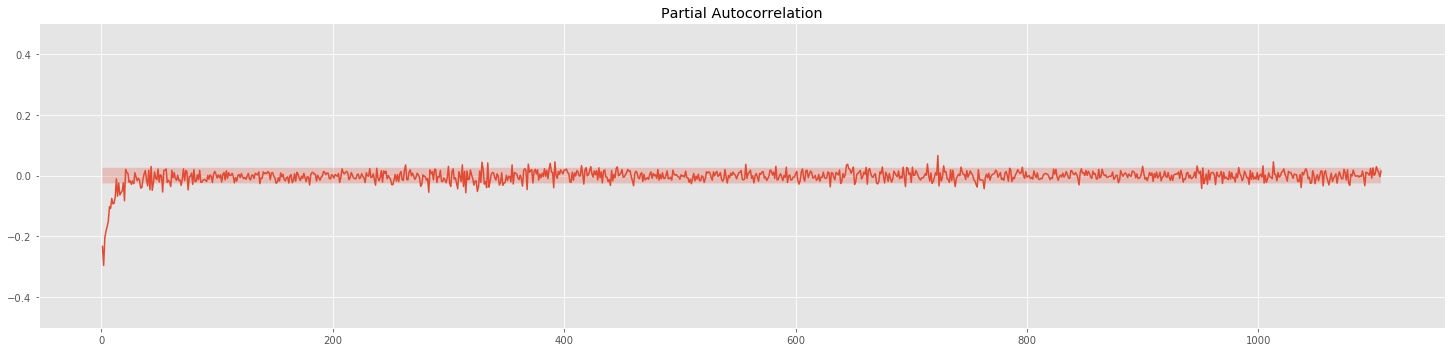

---Differenced SO2 Time Series Plots for Texas ---


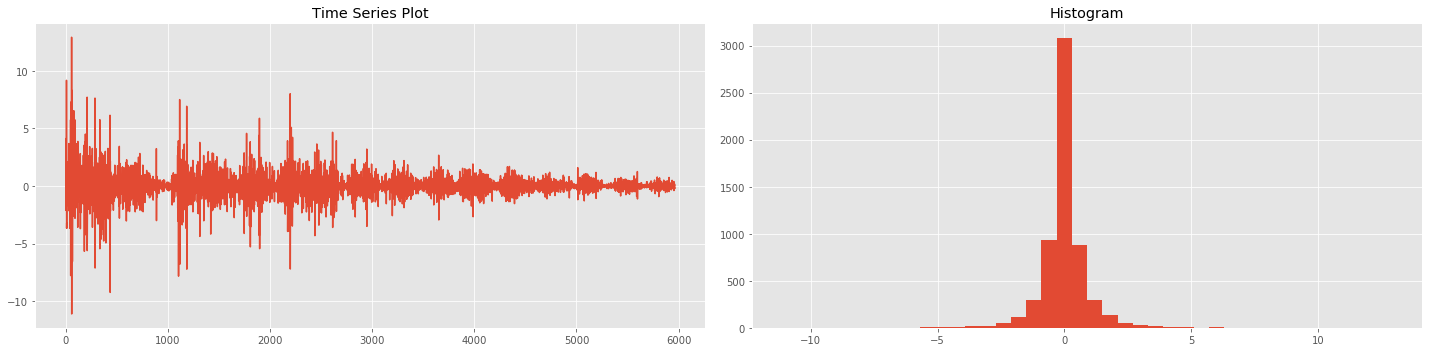

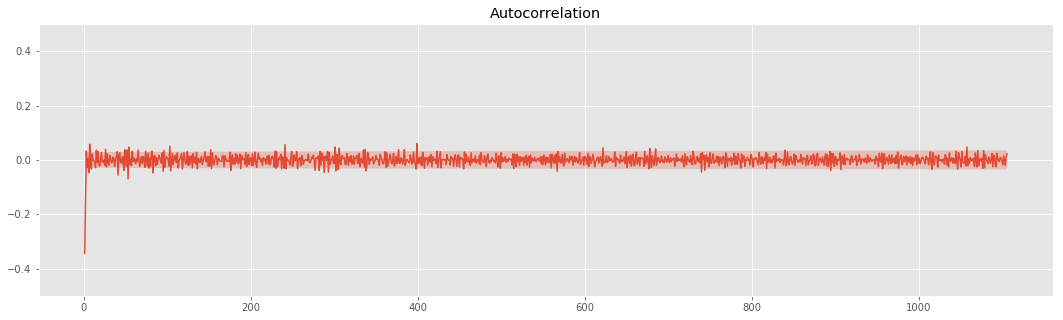

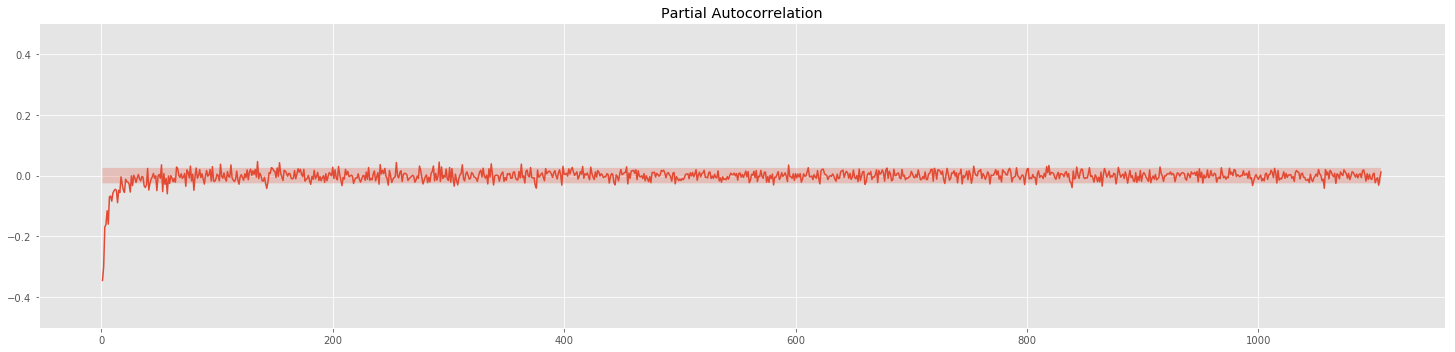

---Differenced SO2 Time Series Plots for New York ---


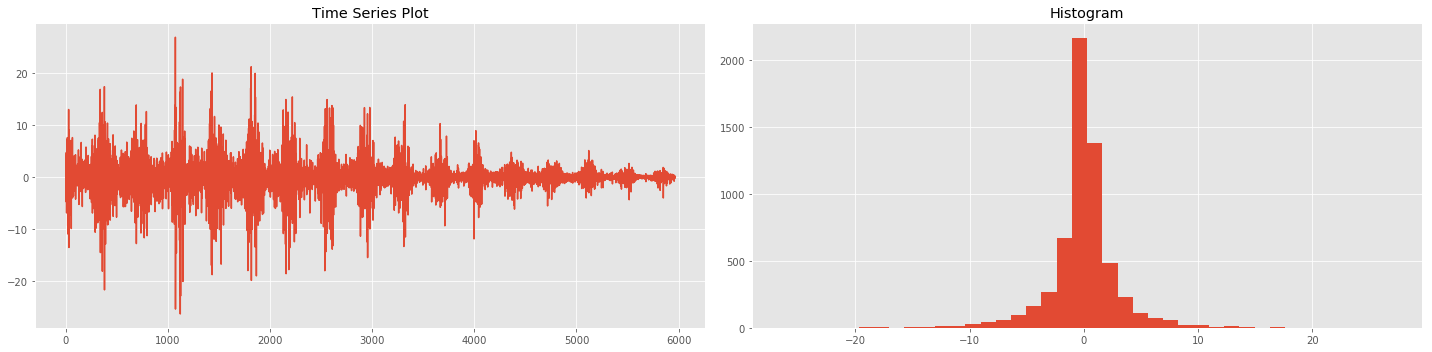

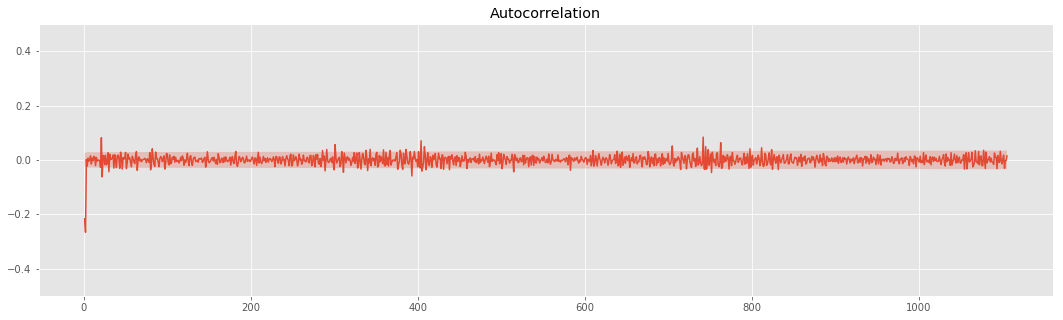

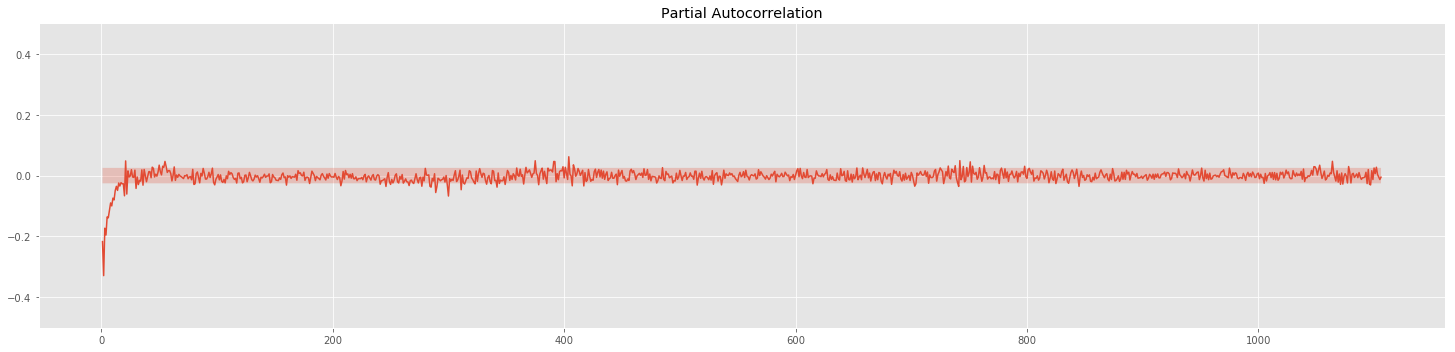

---Differenced SO2 Time Series Plots for Arizona ---


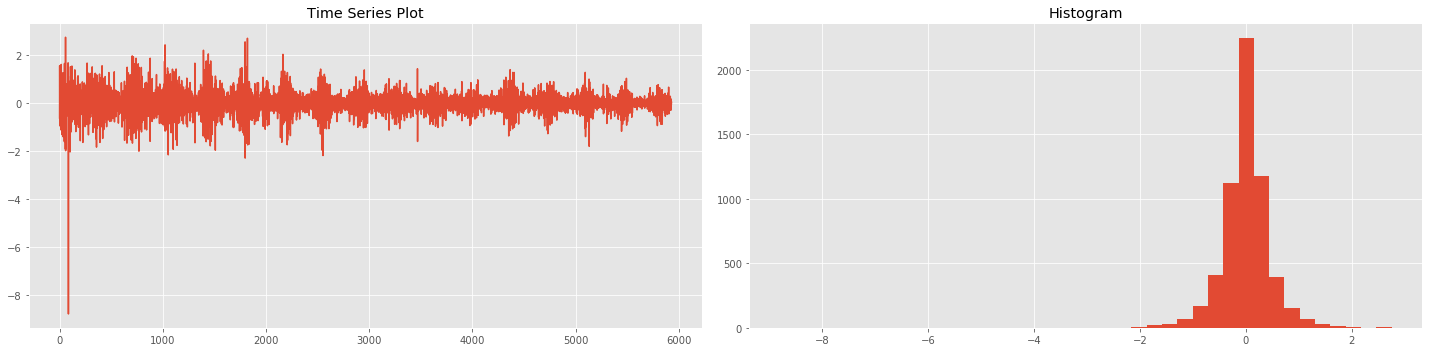

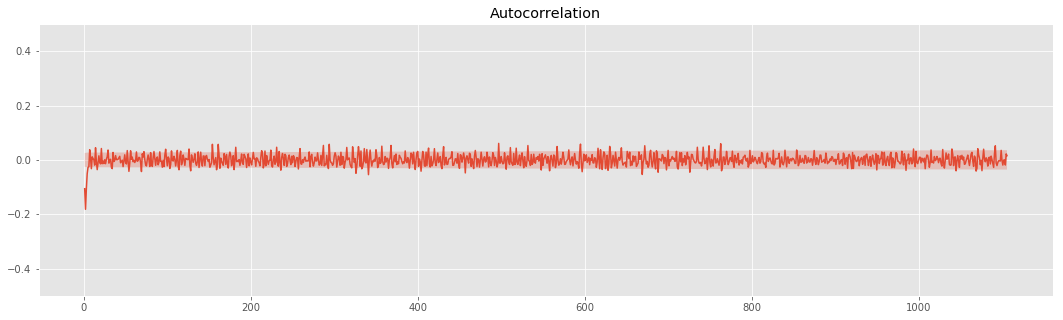

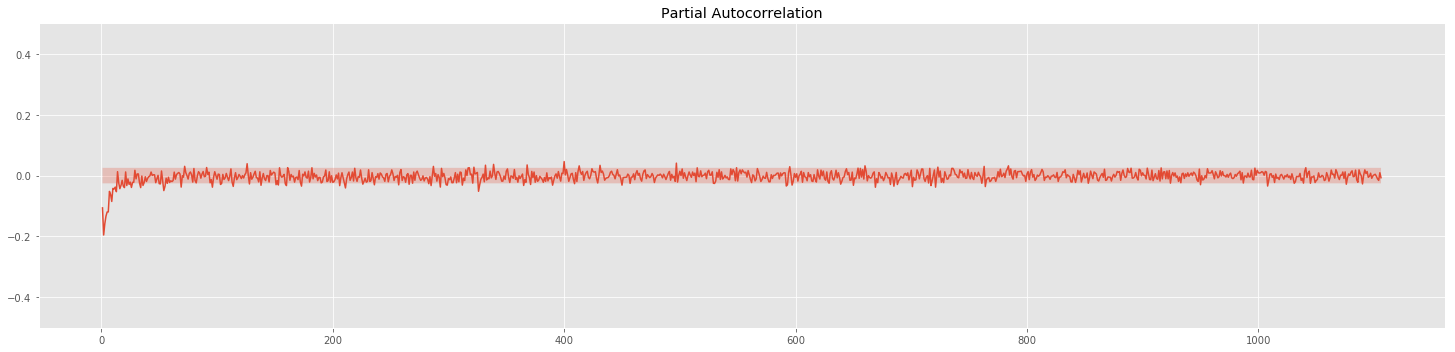

---Differenced SO2 Time Series Plots for Illinois ---


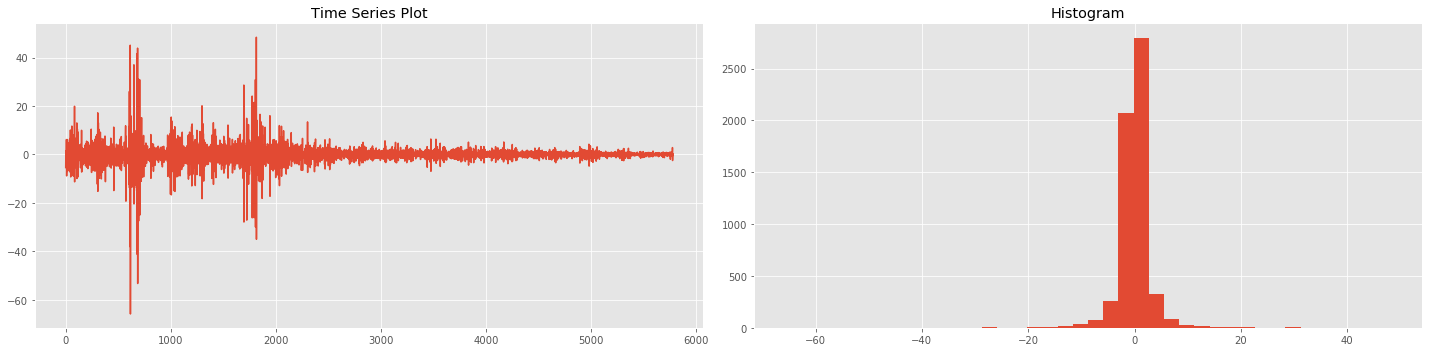

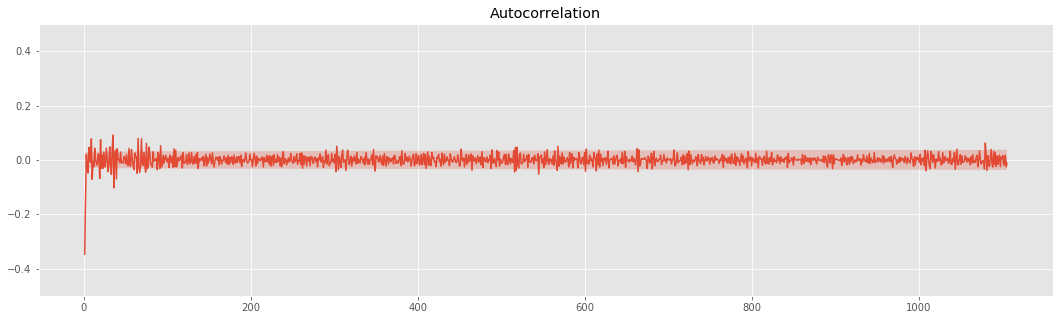

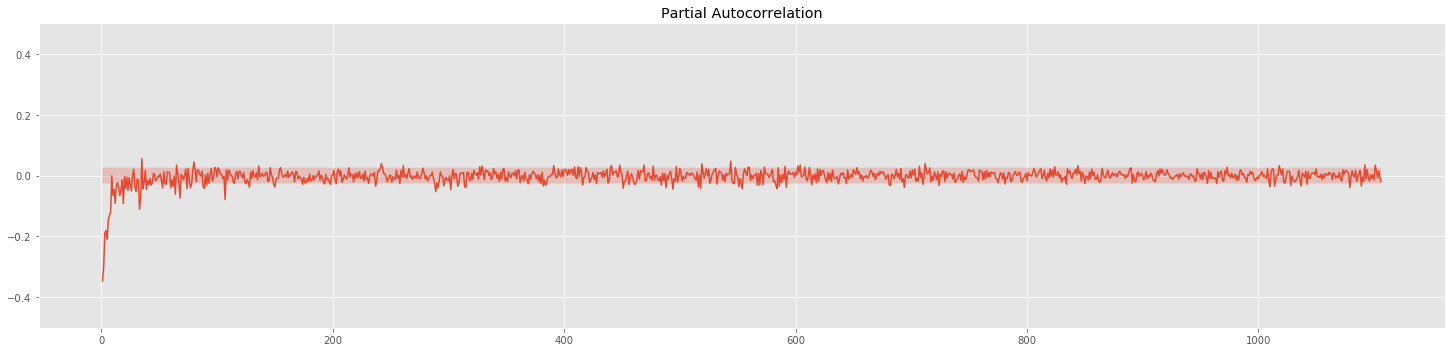

In [20]:
lags = []
for i in SO2_mean_list:
    lags.append(len(i))

#The Number of Lags Corresponds Approximately to 3 Years
lags = np.int(np.mean(lags)*3/16)

for i in np.arange(len(SO2_mean_list)):
    print('---Differenced SO2 Time Series Plots for %s ---' % top_states_list[i])
    tsplot(SO2_mean_list[i].diff().values[1:],figsize=(20,5), lags = lags,zero=False)
    plt.show()

### Creating Training & Hold-Out Datasets 
In order to focus on model training and validation, the training and hold-out datasets will be constructed from solely the California Mean CO data. It has regularly sampled data from 2000-2016 and exhibits seasonality, so it should be sufficient to explore the results of ARIMA modeling. 

In [41]:
cali_data=top_date_agg_statedate_df.loc[top_date_agg_statedate_df['State']=='California']
cali_data['Date']=pd.to_datetime(cali_data['Date'])

cali_reduced_data = cali_data[['Date','CO Mean']]
cali_train = cali_reduced_data.loc[cali_reduced_data['Date'].dt.year<2013]
cali_train=cali_train.reset_index()
cali_train = cali_train.drop(['index'],axis = 1)

cali_test = cali_reduced_data.loc[cali_reduced_data['Date'].dt.year>=2013]
cali_test = cali_test.reset_index()
cali_test = cali_test.drop(['index'],axis = 1)

print('---Training Dataset---')
print cali_train.info()
print cali_train.head()

print('\n---Test Dataset---')
print cali_test.info()
print cali_test.head()

---Training Dataset---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4749 entries, 0 to 4748
Data columns (total 2 columns):
Date       4749 non-null datetime64[ns]
CO Mean    4749 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 74.3 KB
None
        Date   CO Mean
0 2000-01-01  0.608187
1 2000-01-02  0.449850
2 2000-01-03  1.084706
3 2000-01-04  1.243045
4 2000-01-05  1.190961

---Test Dataset---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 2 columns):
Date       1216 non-null datetime64[ns]
CO Mean    1216 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.1 KB
None
        Date   CO Mean
0 2013-01-01  0.581717
1 2013-01-02  0.614674
2 2013-01-03  0.676217
3 2013-01-04  0.690799
4 2013-01-05  0.695379


/Users/mlara/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Non-Seasonal Models (Naive) - {In Progress}

#### Modeling Data as a Naive Non-Seasonal Autoregressive Model 

In [ ]:
# #Model Parameters
# p=[1,2,3,4]
# d=1
# q=0

# # AR(1) Model
# AR1_model = sm.tsa.SARIMAX(cali_train['CO Mean'].diff().values, order=(p[0],d,q),)
# AR1_model_results = MA1_model.fit()
# print('------------------AR(1) Model Summary------------------')
# print('MLE Converged: %s' % (AR1_model_results.mle_retvals['converged']))

# if AR1_model_results.mle_retvals['converged']:
#     print AR1_model_results.summary()
#     AR1_model_results.plot_diagnostics(figsize=(8,8))
#     plt.show()
    
# # AR(2) Model
# AR2_model = sm.tsa.SARIMAX(cali_train['CO Mean'].diff().values, order=(p[1],d,q))
# AR2_model_results = AR2_model.fit()
# print('\n------------------AR(2) Model Summary------------------')
# print('MLE Converged: %s' % (AR2_model_results.mle_retvals['converged']))

# if AR2_model_results.mle_retvals['converged']:
#     print AR2_model_results.summary()
#     AR2_model_results.plot_diagnostics(figsize=(8,8))
#     plt.show()


#### Modeling Data as a Naive Non-Seasonal Moving Average Model 

In [ ]:
# #Model Parameters
# p=0
# d=1
# q=[1,2]

# # MA(1) Model
# MA1_model = sm.tsa.SARIMAX(cali_train['CO Mean'].diff().values, order=(p,d,q[0]),)
# MA1_model_results = MA1_model.fit()
# print('------------------MA(1) Model Summary------------------')
# print('MLE Converged: %s' % (MA1_model_results.mle_retvals['converged']))

# if MA1_model_results.mle_retvals['converged']:
#     print MA1_model_results.summary()
#     MA1_model_results.plot_diagnostics(figsize=(8,8))
#     plt.show()
    
# # MA(2) Model
# # MA2_model = sm.tsa.SARIMAX(cali_train['CO Mean'].diff().values, order=(p,d,q[1]))
# # MA2_model_results = MA2_model.fit()
# # print('\n------------------MA(2) Model Summary------------------')
# # print('MLE Converged: %s' % (MA2_model_results.mle_retvals['converged']))

# # if MA2_model_results.mle_retvals['converged']:
# #     print MA2_model_results.summary()


### Modeling Data as SARIMA Model

In [ ]:
#Model Estimation

#Non-Seasonal Parameters
p=[1,2]
d=[1]
q=[1,2]

#Seasonal Parameters
P=[0]
D=[1]
Q=[1]
s =xrange(350,400,1)

# Fit the model
arima200 = sm.tsa.SARIMAX(ts_train, order=(p,d,q),seasonal_order=(P,D,Q,s))
model_results = arima200.fit()
model_results.summary()